<a href="https://colab.research.google.com/github/yeon524/TEAM_PROJECT/blob/main/%EB%AC%BC%EB%A5%98_%EC%84%BC%ED%84%B0%EC%A0%9C%EC%95%BD_CPEX_%2BORTOOLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 22.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.31.1 

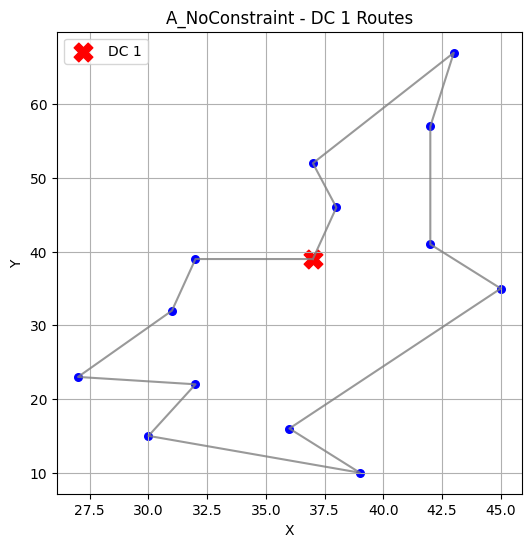

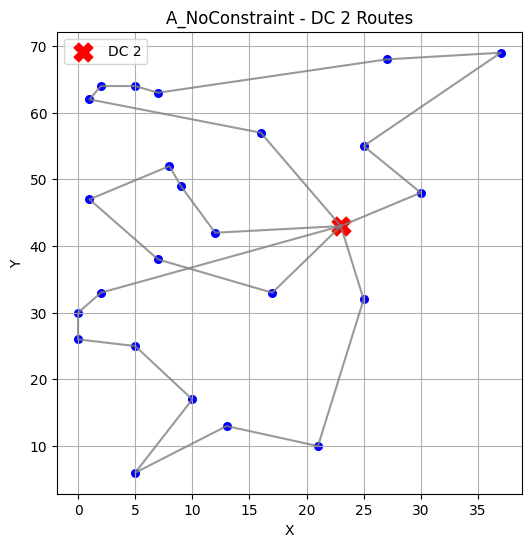

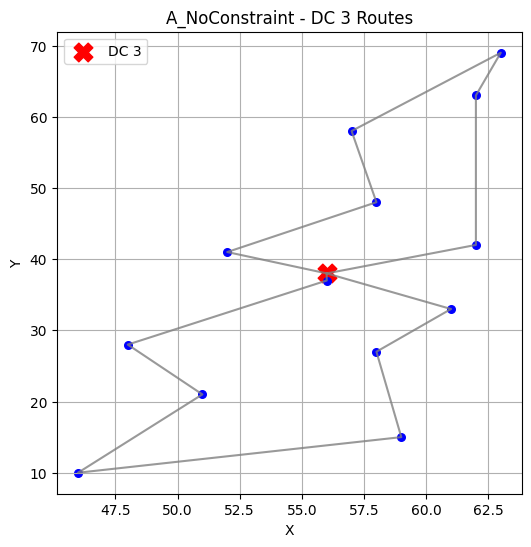


=== B_LambdaOnly — λ grid search ===

[B_LambdaOnly_lam0.1] MILP + VRP 풀이 시작
  λ = 0.1, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.10 → infeasible

[B_LambdaOnly_lam0.15] MILP + VRP 풀이 시작
  λ = 0.15, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.15 → infeasible

[B_LambdaOnly_lam0.2] MILP + VRP 풀이 시작
  λ = 0.2, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.20 → infeasible

[B_LambdaOnly_lam0.25] MILP + VRP 풀이 시작
  λ = 0.25, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Optimal
개설된 DC: [0, 1, 2, 3, 4]
  DC 0 | VRP 거리 = 127.49, routes = [[0, 7, 0], [0, 4, 2, 9, 3, 5, 10, 6, 8, 1, 0]]
  DC 1 | VRP 거리 = 137.80, routes = [[0, 1, 0], [0, 5, 2, 4, 9, 8, 7, 6, 3, 11, 10, 0]]
  DC 2 | VRP 거리 = 168.98, routes = [[0, 4, 5, 1, 10, 0], [0, 9, 12, 7, 2, 3, 6, 11, 8, 0]]
  DC 3 | VRP 거리 = 127.57, routes = [[0, 4, 8, 9, 3, 5,

In [1]:
# =========================================================
# Colab 버전 최종 코드 (튜닝 버전)
# - MILP: PuLP + CPLEX_PY (⚠ cplex 패키지 필수)
# - VRP: OR-Tools CVRP (트럭 용량 160 반영)
# - 케이스 A/B/C/D 4개 한 번에 실행
#   * B: λ 자동 탐색
#   * C: min_cust 자동 탐색
#   * D: (λ, min_cust) 그리드 서치
# =========================================================

!pip install pulp ortools cplex --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pulp
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# ---------------------------------------------
# 0) 데이터 로드
# ---------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index": "Customer_ID"})
dc       = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index": "DC_ID"})
truck    = pd.read_csv("/content/Truck.csv")

C = len(customer)   # 고객 수
D = len(dc)         # DC 수

TRUCK_CAPACITY = int(truck["CAPACITY"].iloc[0])   # 예: 160
open_cost_j    = dc["COST"].values               # DC 개설비용
dc_capacity_j  = dc["CAPACITY"].values           # DC 보관용량

demand        = customer["DEMAND"].values
total_demand  = demand.sum()

cust_coords = [(customer.loc[i, "X"], customer.loc[i, "Y"]) for i in range(C)]
dc_coords   = [(dc.loc[j, "X"],       dc.loc[j, "Y"])       for j in range(D)]

# ---------------------------------------------
# 1) 유틸 (거리)
# ---------------------------------------------
def euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# ---------------------------------------------
# 2) OR-Tools VRP (트럭 용량 160 반영)
# ---------------------------------------------
def solve_vrp_ortools(demands, dist_matrix, vehicle_capacity, num_vehicles=None, time_limit_sec=10):
    """
    demands: [노드별 수요] (0번은 depot이므로 0)
    dist_matrix: NxN 거리행렬
    vehicle_capacity: 트럭 적재 용량 (여기서는 160)
    num_vehicles: None이면 충분히 많은 차량 허용 (3PL)
    """
    n_nodes = len(demands)
    if num_vehicles is None:
        num_vehicles = n_nodes - 1

    manager = pywrapcp.RoutingIndexManager(n_nodes, num_vehicles, 0)  # depot=0
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        f = manager.IndexToNode(from_index)
        t = manager.IndexToNode(to_index)
        return int(dist_matrix[f][t] * 1000)  # 정수화

    transit_cb_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_cb_index)

    def demand_callback(from_index):
        node = manager.IndexToNode(from_index)
        return int(demands[node])

    demand_cb_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_cb_index,
        0,
        [vehicle_capacity] * num_vehicles,
        True,
        "Capacity"
    )

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.FromSeconds(time_limit_sec)

    solution = routing.SolveWithParameters(search_params)
    if not solution:
        return None, None

    routes = []
    total_cost = 0

    for v in range(num_vehicles):
        index = routing.Start(v)
        route = []
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route.append(node)
            prev_index = index
            index = solution.Value(routing.NextVar(index))
            total_cost += routing.GetArcCostForVehicle(prev_index, index, v)
        node = manager.IndexToNode(index)
        route.append(node)
        if len(route) > 2:
            routes.append(route)

    total_cost = total_cost / 1000.0
    return total_cost, routes

# ---------------------------------------------
# 3) MILP 모델 생성 (제약 on/off 옵션)
# ---------------------------------------------
def build_milp_model(lam=None, min_cust=None, use_capacity=True):
    """
    lam      : 균형 제약 λ (None이면 미적용)
    min_cust : 최소 고객 수 (None이면 미적용)
    use_capacity : True면 DC CAPACITY 제약 적용
    """
    model = pulp.LpProblem("FacilityLocation_Generic", pulp.LpMinimize)

    # 변수
    y = pulp.LpVariable.dicts("OpenDC", range(D), cat="Binary")
    x = pulp.LpVariable.dicts("Assign", (range(C), range(D)), cat="Binary")

    # 거리 비용
    dist_cost = np.zeros((C, D))
    for i in range(C):
        for j in range(D):
            dist_cost[i, j] = euclid(cust_coords[i], dc_coords[j])

    # 목적함수: 개설비 + 배정 거리
    model += (
        pulp.lpSum([y[j] * open_cost_j[j] for j in range(D)]) +
        pulp.lpSum([x[i][j] * dist_cost[i, j] for i in range(C) for j in range(D)])
    )

    # (공통) 각 고객은 정확히 하나의 DC에 배정
    for i in range(C):
        model += pulp.lpSum([x[i][j] for j in range(D)]) == 1

    # (공통) DC가 열려야 배정 가능
    for i in range(C):
        for j in range(D):
            model += x[i][j] <= y[j]

    # (선택) 제약 1: 균형 제약 (λ)  → 각 DC가 담당하는 총 수요 상한
    if lam is not None:
        max_load = lam * total_demand
        for j in range(D):
            model += pulp.lpSum([x[i][j] * demand[i] for i in range(C)]) <= max_load

    # (선택) 제약 2: 최소 고객 수 제약
    if min_cust is not None:
        for j in range(D):
            model += pulp.lpSum([x[i][j] for i in range(C)]) >= min_cust * y[j]

    # (선택) DC CAPACITY 제약
    if use_capacity:
        for j in range(D):
            model += pulp.lpSum([x[i][j] * demand[i] for i in range(C)]) <= dc_capacity_j[j]

    return model, x, y

# ---------------------------------------------
# 4) MILP + VRP 한 번에 푸는 함수 (CPLEX_PY 사용)
# ---------------------------------------------
def solve_milp_and_vrp(case_name, lam=None, min_cust=None,
                       use_capacity=True, vrp_time_limit=10,
                       cplex_msg=False, do_plot=False):
    print("\n============================")
    print(f"[{case_name}] MILP + VRP 풀이 시작")
    print(f"  λ = {lam}, MIN_CUST = {min_cust}, CAPACITY_CONSTR = {use_capacity}")
    print("============================")

    # 1) MILP 모델 생성
    model, x, y = build_milp_model(lam=lam, min_cust=min_cust, use_capacity=use_capacity)

    # 2) CPLEX_PY로 풀기
    try:
        solver = pulp.CPLEX_PY(msg=cplex_msg)
    except Exception as e:
        raise RuntimeError("CPLEX_PY solver를 사용할 수 없습니다. Colab에서 'pip install cplex'가 성공했는지 확인하세요.") from e

    status = model.solve(solver)
    status_str = pulp.LpStatus[status]
    print("MILP Status:", status_str)
    if status_str != "Optimal":
        print(" → 최적해를 찾지 못했거나 infeasible 입니다.")
        return None

    # 3) MILP 결과 해석
    opened_centers = []
    assignment     = {}

    for j in range(D):
        if y[j].value() > 0.5:
            opened_centers.append(j)

    for i in range(C):
        for j in range(D):
            if x[i][j].value() > 0.5:
                assignment[i] = j
                break

    if len(opened_centers) == 0:
        print(" → 어떤 DC도 열리지 않음 (infeasible 취급)")
        return None

    print("개설된 DC:", opened_centers)

    open_cost_total = sum(open_cost_j[j] for j in opened_centers)

    # 4) DC별 VRP (truck capacity 160 반영)
    total_vrp_cost = 0.0
    routes_detail  = {}

    for dc_id in opened_centers:
        cust_list = [i for i in range(C) if assignment[i] == dc_id]
        if not cust_list:
            continue

        # 0: depot, 1~k: 고객
        locs = []
        dc_row = dc.loc[dc_id]
        locs.append((dc_row["X"], dc_row["Y"]))
        for cid in cust_list:
            crow = customer.loc[cid]
            locs.append((crow["X"], crow["Y"]))

        n = len(locs)
        dist_matrix = [[euclid(locs[i], locs[j]) for j in range(n)] for i in range(n)]
        demands = [0] + [int(demand[cid]) for cid in cust_list]

        vrp_dist, routes = solve_vrp_ortools(
            demands=demands,
            dist_matrix=dist_matrix,
            vehicle_capacity=TRUCK_CAPACITY,
            num_vehicles=None,
            time_limit_sec=vrp_time_limit
        )

        if vrp_dist is None:
            print(f"  DC {dc_id} VRP 풀이 실패 (infeasible)")
            return None

        total_vrp_cost += vrp_dist
        routes_detail[dc_id] = {
            "routes": routes,
            "locs":  locs,
            "customers": cust_list
        }

        print(f"  DC {dc_id} | VRP 거리 = {vrp_dist:.2f}, routes = {routes}")

    total_cost = open_cost_total + total_vrp_cost

    print(f"\n[{case_name}] 결과 요약")
    print("  개설된 DC:", opened_centers)
    print("  개설비용:", open_cost_total)
    print("  VRP 비용:", total_vrp_cost)
    print("  총비용:", total_cost)

    # 5) 시각화 (옵션)
    if do_plot:
        for dc_id in opened_centers:
            detail = routes_detail[dc_id]
            routes = detail["routes"]
            locs   = detail["locs"]

            plt.figure(figsize=(6,6))
            x_dc, y_dc = locs[0]
            plt.scatter(x_dc, y_dc, c="red", marker="X", s=180, label=f"DC {dc_id}")

            for route in routes:
                xs, ys = [], []
                for node in route:
                    x, y = locs[node]
                    xs.append(x); ys.append(y)
                    if node != 0:
                        plt.scatter(x, y, c="blue", s=30)
                plt.plot(xs, ys, c="gray", alpha=0.8)

            plt.title(f"{case_name} - DC {dc_id} Routes")
            plt.xlabel("X"); plt.ylabel("Y")
            plt.grid(True); plt.legend()
            plt.show()

    result = {
        "case": case_name,
        "lambda": lam,
        "min_cust": min_cust,
        "opened": opened_centers,
        "open_cost": open_cost_total,
        "vrp_cost": total_vrp_cost,
        "total_cost": total_cost,
        "routes_detail": routes_detail,
        "assignment": assignment
    }
    return result

# ---------------------------------------------
# 5) λ / min_cust 후보 자동 생성
# ---------------------------------------------
def lambda_candidates():
    # 0.10 ~ 0.90, 0.05 간격 (필요하면 간격 더 촘촘하게 조절 가능)
    return [round(0.10 + 0.05 * k, 2) for k in range(0, 17)]

def min_cust_candidates():
    # 고객 수 C 기준으로 합리적인 후보 생성 (예: 50명이면 5,10,15,20,25)
    step = max(1, C // 10)
    max_val = max(step, C // 2)
    return list(range(step, max_val + 1, step))

# ---------------------------------------------
# 6) 4가지 케이스 한 번에 실행 (튜닝 포함)
# ---------------------------------------------
results_all = {}

# A. 제약 없음 (한 번만, 플롯도 켜 둠)
results_all["A_None"] = solve_milp_and_vrp(
    case_name="A_NoConstraint",
    lam=None,
    min_cust=None,
    use_capacity=True,
    vrp_time_limit=10,
    do_plot=True
)

# B. 제약 1만 (λ)  → 여러 λ 중 최적 λ 찾기
print("\n=== B_LambdaOnly — λ grid search ===")
best_B = None
for lam in lambda_candidates():
    res = solve_milp_and_vrp(
        case_name=f"B_LambdaOnly_lam{lam}",
        lam=lam,
        min_cust=None,
        use_capacity=True,
        vrp_time_limit=5,
        do_plot=False
    )
    if res is None:
        print(f"  λ={lam:.2f} → infeasible")
        continue
    print(f"  λ={lam:.2f} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
    if (best_B is None) or (res["total_cost"] < best_B["total_cost"]):
        best_B = res
results_all["B_LambdaOnly"] = best_B

# C. 제약 2만 (MIN_CUST) → 여러 min_cust 중 최적 찾기
print("\n=== C_MinCustOnly — min_cust grid search ===")
best_C = None
for mc in min_cust_candidates():
    res = solve_milp_and_vrp(
        case_name=f"C_MinCustOnly_mc{mc}",
        lam=None,
        min_cust=mc,
        use_capacity=True,
        vrp_time_limit=5,
        do_plot=False
    )
    if res is None:
        print(f"  min_cust={mc} → infeasible")
        continue
    print(f"  min_cust={mc} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
    if (best_C is None) or (res["total_cost"] < best_C["total_cost"]):
        best_C = res
results_all["C_MinCustOnly"] = best_C

# D. 제약 1+2 동시 적용 → (λ, min_cust) 조합 전부 탐색
print("\n=== D_Both — (λ, min_cust) grid search ===")
best_D = None
for lam in lambda_candidates():
    for mc in min_cust_candidates():
        res = solve_milp_and_vrp(
            case_name=f"D_Both_lam{lam}_mc{mc}",
            lam=lam,
            min_cust=mc,
            use_capacity=True,
            vrp_time_limit=5,
            do_plot=False
        )
        if res is None:
            print(f"  λ={lam:.2f}, min_cust={mc} → infeasible")
            continue
        print(f"  λ={lam:.2f}, min_cust={mc} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
        if (best_D is None) or (res["total_cost"] < best_D["total_cost"]):
            best_D = res
results_all["D_Both"] = best_D

# ---------------------------------------------
# 7) 최종 비교 출력
# ---------------------------------------------
print("\n================ 최종 비교 ================")
for k, res in results_all.items():
    if res is None:
        print(k, "→ infeasible or failed")
    else:
        print(
            f"{k}: TOTAL={res['total_cost']:.2f}, opened={res['opened']}, "
            f"λ={res['lambda']}, min_cust={res['min_cust']}"
        )
print("==========================================")


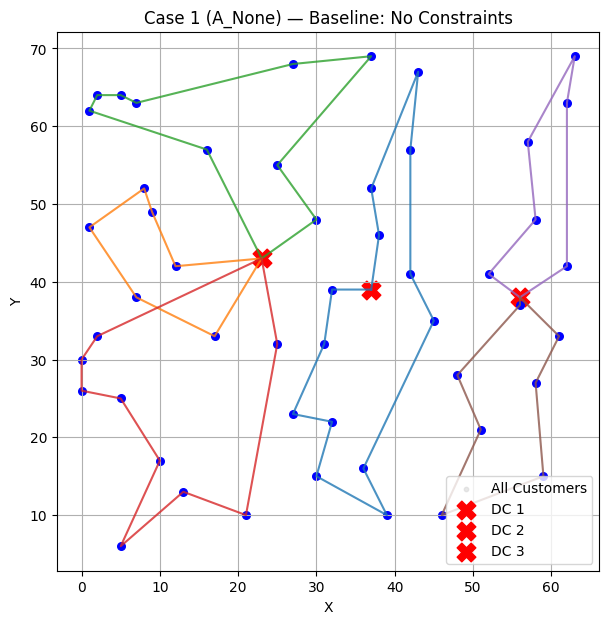

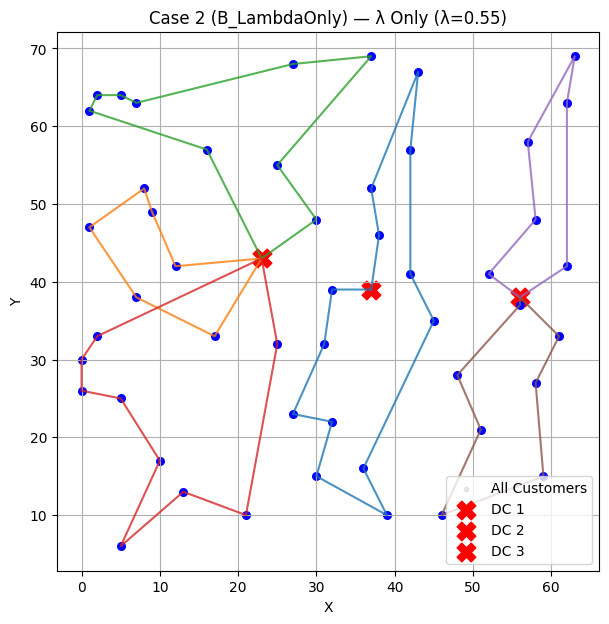

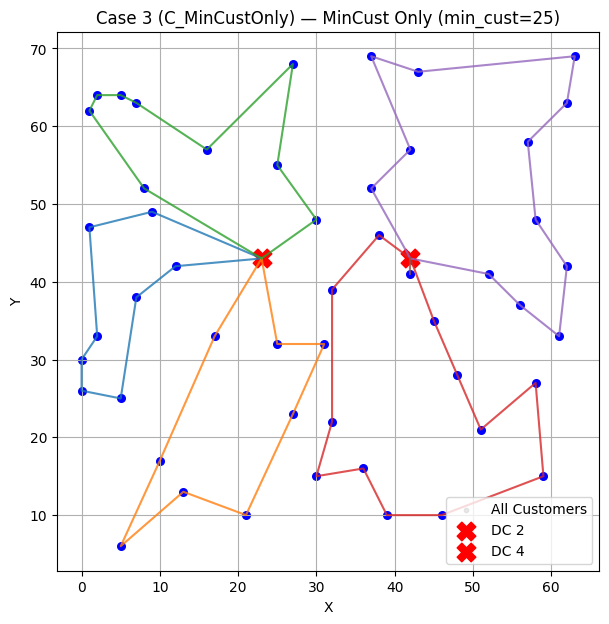

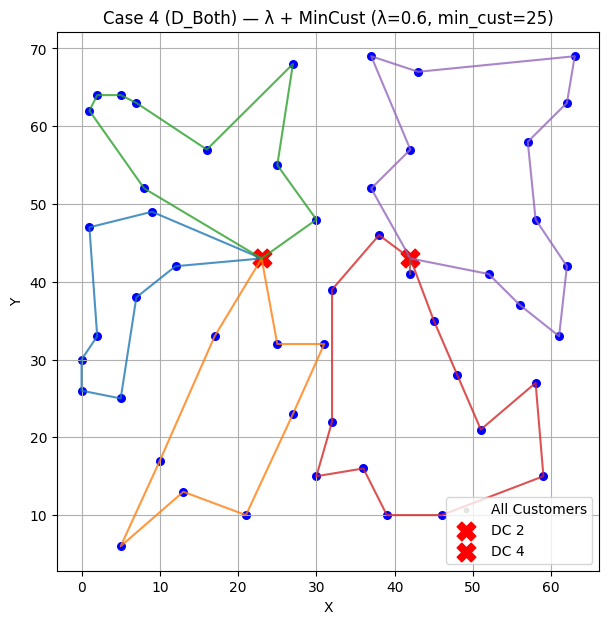

In [2]:
import matplotlib.pyplot as plt

# 케이스 하나를 "한 장"에 그리는 함수
def plot_case_all_dc(result, title=""):
    if result is None:
        print(f"[{title}] 결과가 없습니다 (infeasible or failed).")
        return

    routes_detail = result["routes_detail"]
    opened        = result["opened"]

    plt.figure(figsize=(7, 7))

    # 배경에 전체 고객 위치를 옅게 찍고 싶으면 (선택)
    plt.scatter(customer["X"], customer["Y"],
                c="lightgray", s=10, alpha=0.5, label="All Customers")

    for dc_id in opened:
        detail = routes_detail[dc_id]
        routes = detail["routes"]
        locs   = detail["locs"]   # 0: DC, 1~: 그 DC가 담당하는 고객들

        # DC 표시
        x_dc, y_dc = locs[0]
        plt.scatter(x_dc, y_dc, c="red", marker="X", s=180, label=f"DC {dc_id}")

        # 경로들 표시
        for route in routes:
            xs, ys = [], []
            for node in route:
                x, y = locs[node]
                xs.append(x); ys.append(y)
                if node != 0:
                    plt.scatter(x, y, c="blue", s=30)  # 고객 점
            plt.plot(xs, ys, alpha=0.8)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)

    # 중복 레이블 제거
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.show()


# ============================
# 4개 케이스 각각 시각화 호출
# ============================

plot_case_all_dc(
    results_all["A_None"],
    title="Case 1 (A_None) — Baseline: No Constraints"
)

plot_case_all_dc(
    results_all["B_LambdaOnly"],
    title=f"Case 2 (B_LambdaOnly) — λ Only (λ={results_all['B_LambdaOnly']['lambda']})"
)

plot_case_all_dc(
    results_all["C_MinCustOnly"],
    title=f"Case 3 (C_MinCustOnly) — MinCust Only (min_cust={results_all['C_MinCustOnly']['min_cust']})"
)

plot_case_all_dc(
    results_all["D_Both"],
    title=f"Case 4 (D_Both) — λ + MinCust (λ={results_all['D_Both']['lambda']}, min_cust={results_all['D_Both']['min_cust']})"
)

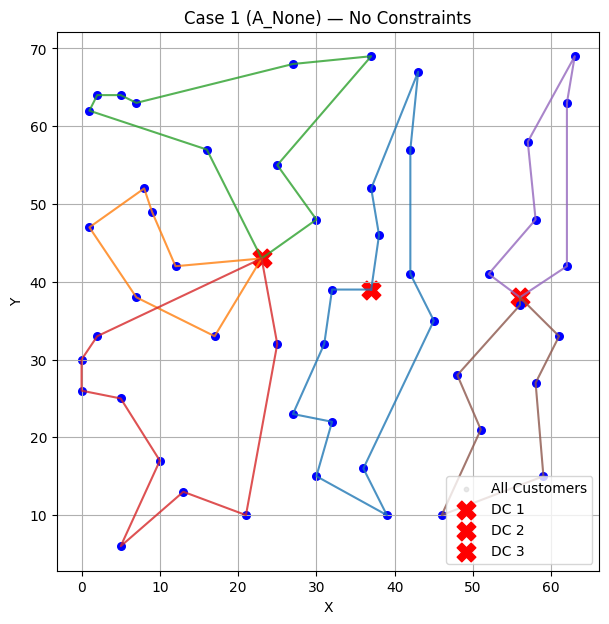

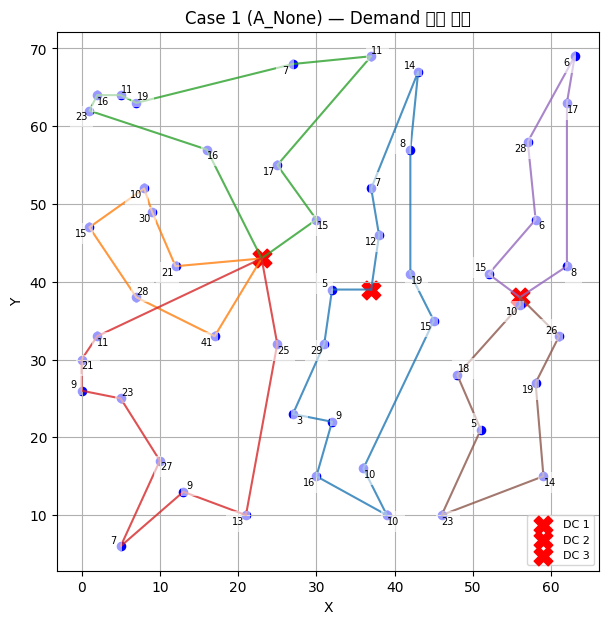

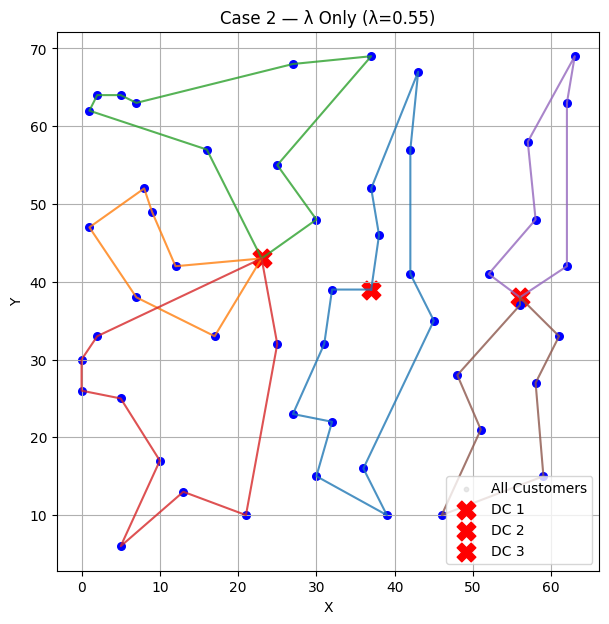

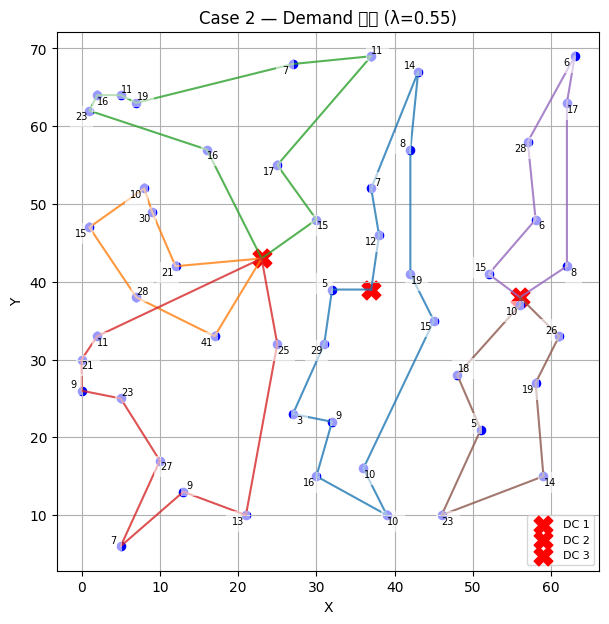

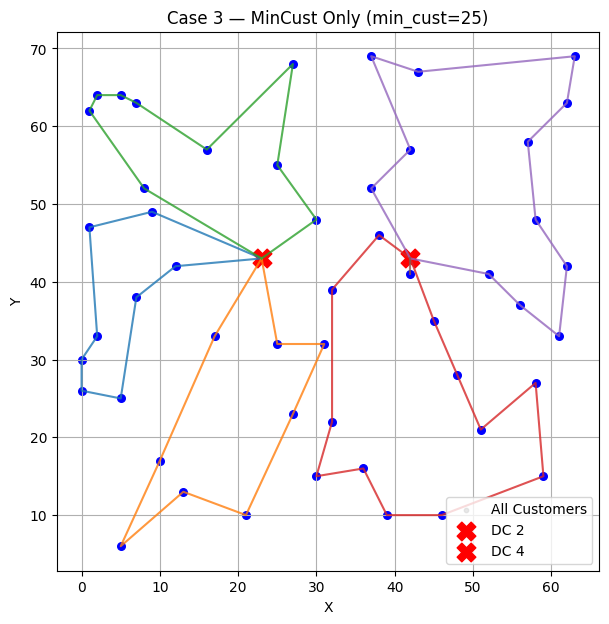

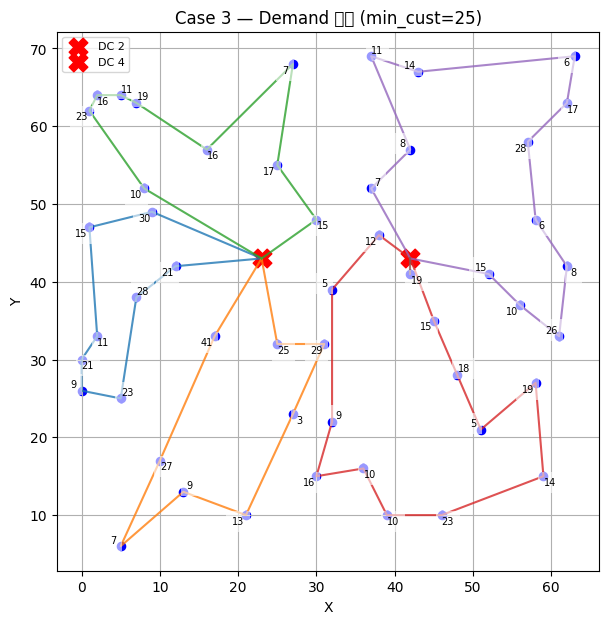

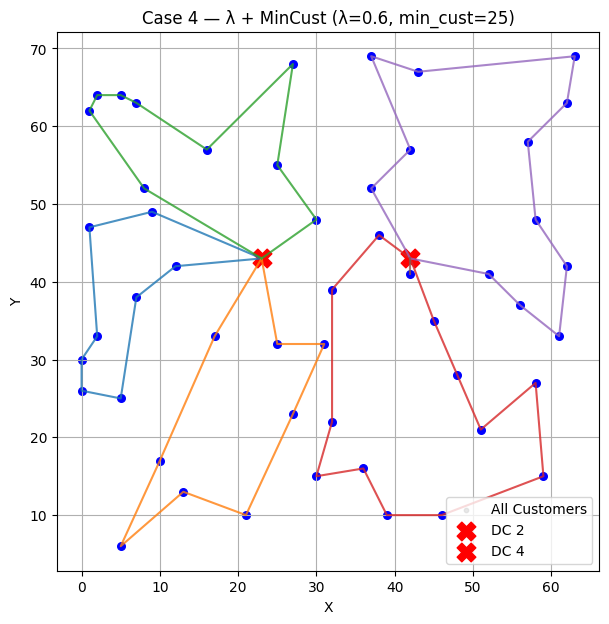

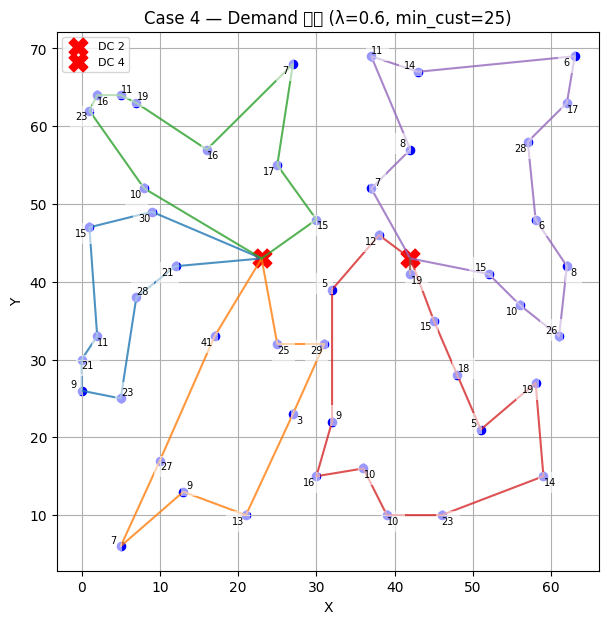

In [5]:
# ================================================================
# Demand(수요) 라벨을 고객 옆에 "한 번만" 표시하는 시각화 버전
# ================================================================
def plot_case_all_dc_with_demand(result, title=""):
    if result is None:
        print(f"[{title}] 결과가 없습니다 (infeasible or failed).")
        return

    routes_detail = result["routes_detail"]
    opened        = result["opened"]

    plt.figure(figsize=(7, 7))

    # 전체 고객 위치만 옅게 찍기 (텍스트 X)
    plt.scatter(customer["X"], customer["Y"],
                c="lightgray", s=15, alpha=0.5)

    # 이미 라벨 찍은 고객은 다시 안 찍도록 관리
    already_labeled = set()

    for dc_id in opened:
        detail = routes_detail[dc_id]
        routes = detail["routes"]
        locs   = detail["locs"]   # depot + 고객 위치들

        # DC
        x_dc, y_dc = locs[0]
        plt.scatter(x_dc, y_dc, c="red", marker="X", s=180, label=f"DC {dc_id}")

        # 경로 표시
        for r_idx, route in enumerate(routes):
            xs, ys = [], []
            for node in route:
                x, y = locs[node]
                xs.append(x); ys.append(y)

                if node != 0:
                    plt.scatter(x, y, c="blue", s=35)

                    # global customer index
                    global_index = detail["customers"][node-1]  # node==1 → customers[0]

                    # 아직 라벨 안 찍은 고객만 표시
                    if global_index not in already_labeled:
                        d = int(customer.loc[global_index, "DEMAND"])

                        # index에 따라 살짝 다른 방향으로 밀어주기 (겹침 완화)
                        dx = 0.8 if (global_index % 2 == 0) else -1.0
                        dy = 0.8 if (global_index % 3 == 0) else -0.8

                        plt.text(
                            x + dx, y + dy, f"{d}",
                            fontsize=7, color="black",
                            ha="center", va="center",
                            bbox=dict(facecolor="white",
                                      edgecolor="none",
                                      alpha=0.6)
                        )
                        already_labeled.add(global_index)

            plt.plot(xs, ys, alpha=0.8)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)

    # 중복 레이블 제거
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=8)

    plt.show()

# ============================
# Case별 2장씩 시각화 호출
# ============================

# ---- Case 1 ----
plot_case_all_dc(
    results_all["A_None"],
    title="Case 1 (A_None) — No Constraints"
)

plot_case_all_dc_with_demand(
    results_all["A_None"],
    title="Case 1 (A_None) — Demand 표시 버전"
)

# ---- Case 2 ----
plot_case_all_dc(
    results_all["B_LambdaOnly"],
    title=f"Case 2 — λ Only (λ={results_all['B_LambdaOnly']['lambda']})"
)

plot_case_all_dc_with_demand(
    results_all["B_LambdaOnly"],
    title=f"Case 2 — Demand 표시 (λ={results_all['B_LambdaOnly']['lambda']})"
)

# ---- Case 3 ----
plot_case_all_dc(
    results_all["C_MinCustOnly"],
    title=f"Case 3 — MinCust Only (min_cust={results_all['C_MinCustOnly']['min_cust']})"
)

plot_case_all_dc_with_demand(
    results_all["C_MinCustOnly"],
    title=f"Case 3 — Demand 표시 (min_cust={results_all['C_MinCustOnly']['min_cust']})"
)

# ---- Case 4 ----
plot_case_all_dc(
    results_all["D_Both"],
    title=f"Case 4 — λ + MinCust (λ={results_all['D_Both']['lambda']}, min_cust={results_all['D_Both']['min_cust']})"
)

plot_case_all_dc_with_demand(
    results_all["D_Both"],
    title=f"Case 4 — Demand 표시 (λ={results_all['D_Both']['lambda']}, min_cust={results_all['D_Both']['min_cust']})"
)
